In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read metadata and data from Github
df_meta = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv")
df_measurements = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz", low_memory=False)
# Merge metadata and measurement data by building_id
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')
# Replace two outdoor temperature columns by a new column called t_out_combined
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])
print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total occupants:', len(df_rawdata))

Total buildings: 809
Total occupants: 109033


In [3]:
df_data_1 = df_rawdata.dropna(subset=['top', 'thermal_sensation', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_1['building_id'].unique()))
print(f'Buildings occupants without missing data:', len(df_data_1))

Buildings without missing data: 553
Buildings occupants without missing data: 38467


In [4]:
def accuracy(slope, intercept, range, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df['count_1'] = np.where(
        # Wrong: predict warm when temp lower the range
        ((df.thermal_sensation > 0.85) & (df[temp] < df.t_out_combined * slope + intercept - range/2)), 1, 0)   
    df['count_2'] = np.where(
        # Wrong: predict warm when temp witn the range
        ((df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2) &
        (df.thermal_sensation > 0.85)), 1, 0)   
    df['count_3'] = np.where(
        # Correct: predict warm when temp higher the range
        ((df.thermal_sensation > 0.85) & (df[temp] > df.t_out_combined * slope + intercept + range/2)), 1, 0)   
    df['count_4'] = np.where(
        # Wrong: predict comfortable when temp lower range
        ((df.thermal_sensation >= -0.85) & 
        (df.thermal_sensation <= 0.85) & 
        (df[temp] <= df.t_out_combined * slope + intercept - range/2)), 1, 0)       
    df['count_5'] = np.where(
        # Correct: predict comfortable when within range
        ((df.thermal_sensation >= -0.85) & 
        (df.thermal_sensation <= 0.85) & 
        (df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2)), 1, 0)   
    df['count_6'] = np.where(
        # Wrong: predict comfortable when temp higher range
        ((df.thermal_sensation >= -0.85) & 
        (df.thermal_sensation <= 0.85) & 
        (df[temp] >= df.t_out_combined * slope + intercept + range/2)), 1, 0)      
    df['count_7'] = np.where(
        # Correct: predict cool when lower the range
        ((df.thermal_sensation < -0.85) & (df[temp] < df.t_out_combined * slope + intercept - range/2)), 1, 0)   
    df['count_8'] = np.where(
        # Wrong: predict cool when witn the range
        ((df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2) &
        (df.thermal_sensation < -0.85)), 1, 0)
    df['count_9'] = np.where(
        # Wrong: predict cool when temp higher the range
        ((df[temp] >= df.t_out_combined * slope + intercept + range/2) &
        (df.thermal_sensation < -0.85)), 1, 0)
    # add all the counts and divide by total records
    percent = (df.count_3 + df.count_5 + df.count_7).sum() / len(df)
    print("total records: ", len(df))
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:  # Now 'range' can be used as intended, as the built-in function
        print(i, df[f'count_{i}'].sum())
    return percent

In [5]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_1 = df_data_1.copy()
df_data_1['cooling_type'] = df_data_1['cooling_type'].str.title()
df_data_1_NV = df_data_1[df_data_1['cooling_type'] == 'Naturally Ventilated']
print(f'NV building occupants without missing data:', len(df_data_1_NV))

NV building occupants without missing data: 19685


## ASHRAE ACM prediction accuracy

In [6]:
slope = 0.31
intercept = 17.8
range = 7
df_data_1_NV = df_data_1_NV.copy()
result = 100 * accuracy(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, NV building: {:.0f} %'.format(result))

total records:  19685
1 22
2 4961
3 2912
4 442
5 6120
6 1382
7 840
8 2825
9 181
All TSV prediction accraucy, NV building: 50 %


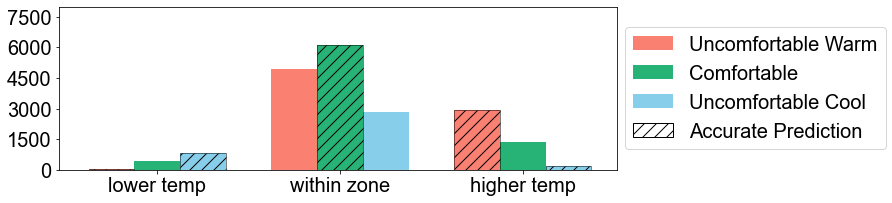

In [8]:
# value 1, 2, 3
hot = [22, 4961, 2912]
# value 4, 5, 6
comfort = [442, 6120, 1382]
# value 7, 8, 9
cool = [840, 2825, 181]

# Data
categories = ['lower temp', 'within zone', 'higher temp']
# Position of bars on x-axis
ind = np.arange(len(categories))
# Width of a bar
width = 0.25
# Size of the plot
plt.figure(figsize=(10, 3))
# Side by side bar chart
bars_hot = plt.bar(ind - width, hot, width, color='#FA8072', label='Uncomfortable Warm')
bars_comfort = plt.bar(ind, comfort, width, color='#27b376', label='Comfortable')
bars_cool = plt.bar(ind + width, cool, width, color='#87CEEB', label='Uncomfortable Cool')
# Adding hatching only to specific bars (highlighted parts)
plt.bar(ind[0] + width, cool[0], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Cool part in Bar 1
plt.bar(ind[2] + width, cool[2], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Cool part in Bar 1
plt.bar(ind[1], comfort[1], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Comfort part in Bar 2
plt.bar(ind[0] - width, hot[0], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Hot part in Bar 3
plt.bar(ind[2] - width, hot[2], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Hot part in Bar 3
# X-ticks
plt.yticks(np.arange(0, 8000, 1500), fontsize=20)
plt.ylim(0, 8000)
plt.xticks(ind, categories, fontsize=20)
plt.rcParams['font.family'] = 'Arial'
# Legend
plt.legend(loc='upper right', fontsize=20)
# Adding a separate legend entry for the highlighted (hatched) parts
plt.bar(0, 0, color='none', edgecolor='black', hatch='//', label='Accurate Prediction')
# Reordering legend to include all four labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2, 3]  # Adjust order to match your preference
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize=20)
# Save the figure
plt.savefig('figs/fig_accuracy.pdf', format='pdf', bbox_inches='tight')
# Show the chart
plt.show()

In [304]:
# divide each number in hot, comfort, and cool by 19685
print([i / 19685 * 100 for i in hot])
print([i / 19685 * 100 for i in comfort])
print([i / 19685 * 100 for i in cool])

[0.11176022352044704, 25.201930403860807, 14.792989585979171]
[2.2453644907289814, 31.089662179324357, 7.020574041148082]
[4.267208534417069, 14.351028702057404, 0.919481838963678]


## Constant zone prediction accuracy

In [16]:
slope = 0
intercept = 23
range = 12
result = 100 * accuracy(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, all NV building: {:.0f} %'.format(result))

total records:  19685
1 3
2 4861
3 3031
4 188
5 6161
6 1614
7 694
8 2958
9 195
All TSV prediction accraucy, all NV building: 50 %


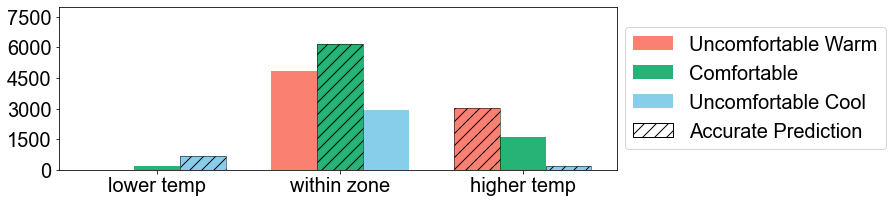

In [17]:
# value 1, 2, 3
hot = [3, 4861, 3031]
# value 4, 5, 6
comfort = [188, 6161, 1614]
# value 7, 8, 9
cool = [694, 2958, 195]

# Data
categories = ['lower temp', 'within zone', 'higher temp']
# Position of bars on x-axis
ind = np.arange(len(categories))
# Width of a bar
width = 0.25
# Size of the plot
plt.figure(figsize=(10, 3))
# Side by side bar chart
bars_hot = plt.bar(ind - width, hot, width, color='#FA8072', label='Uncomfortable Warm')
bars_comfort = plt.bar(ind, comfort, width, color='#27b376', label='Comfortable')
bars_cool = plt.bar(ind + width, cool, width, color='#87CEEB', label='Uncomfortable Cool')
# Adding hatching only to specific bars (highlighted parts)
plt.bar(ind[0] + width, cool[0], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Cool part in Bar 1
plt.bar(ind[2] + width, cool[2], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Cool part in Bar 1
plt.bar(ind[1], comfort[1], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Comfort part in Bar 2
plt.bar(ind[0] - width, hot[0], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Hot part in Bar 3
plt.bar(ind[2] - width, hot[2], width, color='none', edgecolor='black', hatch='//', linewidth=0.5)  # Hot part in Bar 3
# X-ticks
plt.yticks(np.arange(0, 8000, 1500), fontsize=20)
plt.ylim(0, 8000)
plt.xticks(ind, categories, fontsize=20)
plt.rcParams['font.family'] = 'Arial'
# Legend
plt.legend(loc='upper right', fontsize=20)
# Adding a separate legend entry for the highlighted (hatched) parts
plt.bar(0, 0, color='none', edgecolor='black', hatch='//', label='Accurate Prediction')
# Reordering legend to include all four labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2, 3]  # Adjust order to match your preference
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize=20)
# Save the figure
plt.savefig('figs/fig_accuracy_constant.pdf', format='pdf', bbox_inches='tight')
# Show the chart
plt.show()

In [18]:
# divide each number in hot, comfort, and cool by 19685
print([i / 19685 * 100 for i in hot])
print([i / 19685 * 100 for i in comfort])
print([i / 19685 * 100 for i in cool])

[0.01524003048006096, 24.693929387858777, 15.39751079502159]
[0.9550419100838201, 31.297942595885193, 8.199136398272797]
[3.5255270510541026, 15.026670053340109, 0.9906019812039624]
